In [1]:
import os, time, copy
from collections import OrderedDict
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as vmodels
import torchvision.datasets as vdatasets

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.patches as patches
import matplotlib.font_manager as fm
path = '/Library/Fonts/NanumBarunGothicBold.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

from PIL import Image as pil_image

import numpy as np
from skimage.transform import resize
from skimage.measure import label, regionprops

torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
BATCH_SIZE = 4

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(197),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((197, 197)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
data_dir = "../datasets/presidential_candidates_2017/"
image_datasets = {x: vdatasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'validation']}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
               'validation': torch.utils.data.DataLoader(image_datasets['validation'], BATCH_SIZE, shuffle=False)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
nb_classes = len(image_datasets['train'].classes)

In [5]:
class Resnet_fc(nn.Module):
    def __init__(self, base_model, nb_classes):
        super(Resnet_fc, self).__init__()

        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])

        tmp = OrderedDict()
        tmp['last_conv'] = nn.Conv2d(2048, nb_classes, 1, 1)
        tmp['gap'] = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)

        self.classifier_layer = nn.Sequential(tmp)

    def forward(self, inputs):
        features = self.feature_extractor(inputs)
        x = self.classifier_layer(features)
        return F.sigmoid(x), features

In [6]:
base_model = vmodels.resnet50(pretrained=False)
net = Resnet_fc(base_model, 5)
net.load_state_dict(torch.load("../weights/pred_fullyconv/mse/best_model_e25_val_acc0.96.pth.tar", map_location='cpu'))
# net.load_state_dict(torch.load("../weights/pred_fullyconv/best_model_e16_val_acc0.95.pth.tar", map_location='cpu'))
net.eval()
net.to(device)


Resnet_fc(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64

In [7]:
image_datasets['train'].class_to_idx

{'ahn': 0, 'hong': 1, 'moon': 2, 'sim': 3, 'you': 4}

In [8]:
img_path = "samples/moon3.JPG"
cls = 2


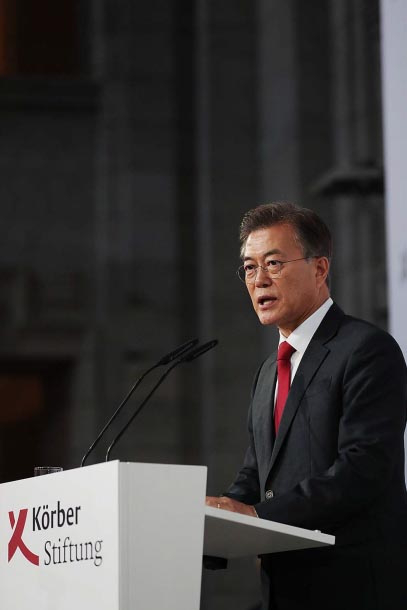

In [9]:
pil_image.open(img_path)

In [59]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

def run_cam(img_path, cls, factor):

    img = pil_image.open(img_path)
    img_array = (np.asarray(img)[:, :, :3] / 255.).astype(float)
    n_H, n_W, n_C = img_array.shape
    
    img_array = resize(img_array, (int(n_H * factor), int(n_W * factor)))
    n_H, n_W, n_C = img_array.shape
    to_feed = copy.deepcopy(img_array)

    inp_tensor = normalize(torch.from_numpy(to_feed.transpose(2, 0, 1))).unsqueeze(0).float()
    inp_tensor = inp_tensor.to(device)

    outputs, features = net(inp_tensor)
    print(np.round(outputs[:, cls, :, :].detach().cpu().numpy(), 2))
    cls_output = torch.max(outputs, dim=1)[1][0, :, :]

    s_1, s_2 = features.size()[2:]
    sl_1 = s_1-7+1
    sl_2 = s_2-7+1
    
    W_conv = net.classifier_layer.last_conv.weight.detach()
    W_conv_c = W_conv[cls]
    
    A_conv_c = torch.zeros(1, s_1, s_2)
    for i in range(sl_1):
        for j in range(sl_2):
            a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
            A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
    _min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
    _max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
    A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)
    canvas = A_conv_c_normalized[0].detach().numpy()

    plt.imshow(img_array)
    plt.imshow(resize(canvas, (n_H, n_W)), cmap='jet', alpha=0.5)
    plt.axis("off")
    plt.show()

/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01]
  [0.01 0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
  [0.02 0.02 0.02 0.03 0.04 0.04 0.04 0.05 0.05 0.04 0.04 0.04 0.05 0.07]
  [0.07 0.08 0.08 0.11 0.14 0.16 0.17 0.19 0.19 0.19 0.18 0.2  0.23 0.24]
  [0.18 0.2  0.21 0.25 0.28 0.3  0.32 0.35 0.36 0.37 0.38 0.39 0.42 0.43]]]


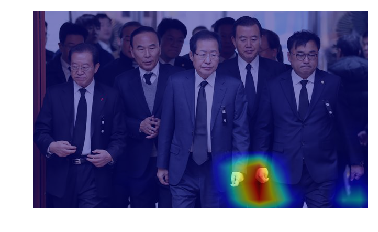

[[[0.02 0.02 0.03 0.05 0.06 0.06 0.04 0.02 0.01 0.01 0.01 0.   0.   0.01]
  [0.02 0.02 0.03 0.04 0.06 0.06 0.04 0.02 0.02 0.01 0.01 0.   0.   0.01]
  [0.02 0.02 0.03 0.04 0.05 0.05 0.04 0.03 0.02 0.02 0.01 0.01 0.01 0.01]
  [0.02 0.02 0.03 0.04 0.05 0.05 0.04 0.03 0.03 0.02 0.02 0.01 0.01 0.02]
  [0.04 0.04 0.04 0.06 0.07 0.06 0.05 0.05 0.05 0.04 0.04 0.03 0.04 0.04]
  [0.08 0.08 0.08 0.09 0.11 0.1  0.08 0.07 0.07 0.07 0.06 0.06 0.06 0.07]]]


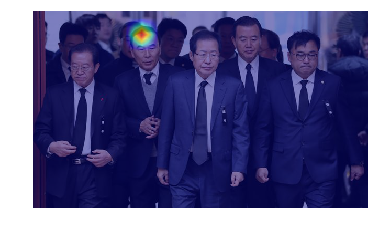

[[[0.85 0.86 0.83 0.66 0.45 0.4  0.57 0.72 0.83 0.88 0.93 0.95 0.94 0.88]
  [0.86 0.88 0.86 0.71 0.51 0.44 0.57 0.68 0.78 0.84 0.9  0.93 0.92 0.84]
  [0.86 0.88 0.85 0.71 0.52 0.43 0.5  0.55 0.64 0.71 0.79 0.84 0.82 0.73]
  [0.73 0.76 0.73 0.59 0.43 0.34 0.34 0.33 0.37 0.42 0.49 0.54 0.53 0.46]
  [0.48 0.5  0.48 0.4  0.31 0.25 0.22 0.19 0.19 0.22 0.24 0.25 0.24 0.23]
  [0.26 0.28 0.29 0.28 0.26 0.24 0.2  0.18 0.18 0.19 0.19 0.18 0.17 0.16]]]


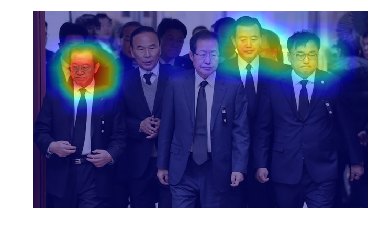

[[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.01]
  [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
  [0.02 0.01 0.01 0.02 0.02 0.03 0.02 0.02 0.02 0.02 0.01 0.02 0.02 0.03]
  [0.03 0.03 0.03 0.04 0.05 0.05 0.05 0.06 0.05 0.05 0.04 0.05 0.06 0.08]
  [0.09 0.09 0.1  0.12 0.13 0.14 0.14 0.15 0.14 0.14 0.13 0.14 0.17 0.19]
  [0.17 0.18 0.19 0.21 0.23 0.23 0.23 0.22 0.21 0.21 0.2  0.21 0.24 0.27]]]


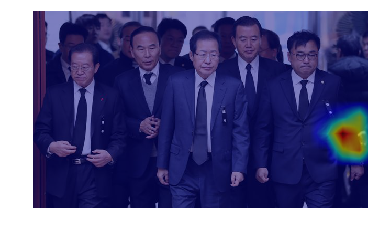

[[[0.19 0.16 0.15 0.23 0.33 0.38 0.32 0.28 0.27 0.25 0.19 0.16 0.15 0.2 ]
  [0.17 0.13 0.13 0.2  0.29 0.36 0.31 0.28 0.28 0.28 0.21 0.18 0.16 0.21]
  [0.15 0.11 0.11 0.18 0.28 0.37 0.35 0.34 0.36 0.36 0.28 0.24 0.21 0.24]
  [0.21 0.17 0.17 0.23 0.34 0.43 0.42 0.41 0.42 0.42 0.36 0.31 0.26 0.27]
  [0.3  0.27 0.26 0.3  0.37 0.43 0.42 0.39 0.38 0.38 0.35 0.31 0.27 0.27]
  [0.39 0.36 0.34 0.33 0.35 0.37 0.34 0.29 0.27 0.26 0.24 0.22 0.2  0.21]]]


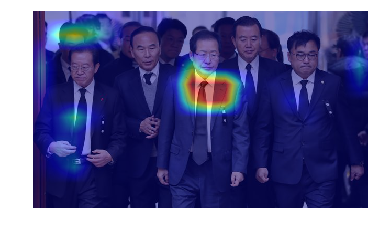

In [60]:
for i in range(5):
    run_cam("samples/hong1.jpg", i, 1)
    

In [52]:
nw

18

tensor(0.1910)
tensor(0.1568)
tensor(0.1547)
tensor(0.2341)
tensor(0.3264)
tensor(0.3847)
tensor(0.3221)
tensor(0.2832)
tensor(0.2660)
tensor(0.2514)
tensor(0.1933)
tensor(0.1630)
tensor(0.1524)
tensor(0.1744)
tensor(0.1346)
tensor(0.1291)
tensor(0.1968)
tensor(0.2880)
tensor(0.3564)
tensor(0.3082)
tensor(0.2832)
tensor(0.2829)
tensor(0.2761)
tensor(0.2129)
tensor(0.1781)
tensor(0.1620)
tensor(0.1512)
tensor(0.1149)
tensor(0.1114)
tensor(0.1792)
tensor(0.2797)
tensor(0.3699)
tensor(0.3481)
tensor(0.3395)
tensor(0.3556)
tensor(0.3557)
tensor(0.2836)
tensor(0.2389)
tensor(0.2103)
tensor(0.2094)
tensor(0.1703)
tensor(0.1669)
tensor(0.2344)
tensor(0.3358)
tensor(0.4268)
tensor(0.4219)
tensor(0.4088)
tensor(0.4229)
tensor(0.4241)
tensor(0.3580)
tensor(0.3069)
tensor(0.2630)
tensor(0.3031)
tensor(0.2670)
tensor(0.2581)
tensor(0.2998)
tensor(0.3700)
tensor(0.4320)
tensor(0.4204)
tensor(0.3891)
tensor(0.3850)
tensor(0.3822)
tensor(0.3468)
tensor(0.3079)
tensor(0.2676)


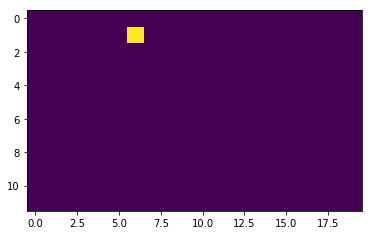

In [55]:

nb, nc, nh, nw = features.size()

A_conv_c = torch.zeros((1, nh, nw))
for h in range(nh-7):
    for w in range(nw-7):
        
        print(outputs[0, 4, h, w])
        
        W_conv = net.classifier_layer.last_conv.weight.detach()
        W_conv_c = W_conv[1]
        
        a_conv_c = (features[:,:,h:h+7,w:w+7] * W_conv_c).sum(1)
        A_conv_c[:, h:h+7, w:w+7] = torch.max(A_conv_c[:, h:h+7, w:w+7], a_conv_c)
plt.imshow(resize(A_conv_c.detach().numpy()[0], ())
plt.show()

#         A_conv_c = torch.zeros(1, s_1, s_2)
#         for i in range(sl_1):
#             for j in range(sl_2):
#                 a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
                
#                 plt.imshow(a_conv_c)
#                 A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
                


In [ ]:
np.where((outputs > 0.4).max(-1)[0].max(-1)[0].detach().numpy()[0]> 0)[0]

In [ ]:
softmax_outputs = F.softmax(outputs, dim=1)
thres_outputs = softmax_outputs >= 0.4
cls_exists = (thres_outputs.sum(-1).sum(-1) > 0).numpy().tolist()

In [64]:
test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [65]:
cls2name = {0: '안철수', 1: '홍준표', 2:'문재인', 3:'심상정', 4:'유승민'}
cls2color = {0: 'green', 1: 'red', 2:'blue', 3:'yellow', 4:'teal'}

In [86]:
def run_inference(img_path, is_heatmap, save=False, save_dir=None):
    img = pil_image.open(img_path)
    img_array = np.asarray(img)[:, :, :3]
    n_H, n_W, n_C = img_array.shape
    
    to_feed = copy.deepcopy(img_array)
    inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
    inp_tensor = inp_tensor.to(device)
    
    output, features = net(inp_tensor)
#       max_label = torch.max(F.softmax(output[0], dim=0), dim=0)[1].int()
#     thres = (torch.max(F.softmax(output[0], dim=0), dim=0)[0] < 0.8)
#     extracted_labels = [x for x in np.unique(max_label.masked_fill(thres, -1).view(-1).numpy()).tolist() if x != -1]
    
#     print(np.round(output.detach().numpy(), 2))
#     
    extracted_labels = np.where((output > 0.3).max(-1)[0].max(-1)[0].detach().numpy()[0]> 0)[0]
#     print(extracted_labels)
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img_array)
    ax.axis("off")
    
    if len(extracted_labels) > 0:
        
        for cls in extracted_labels:
    
            s_1, s_2 = features.size()[2:]

            sl_1 = s_1-7+1
            sl_2 = s_2-7+1

            W_conv = net.classifier_layer.last_conv.weight.detach()
            W_conv_c = W_conv[cls]
            
            A_conv_c = torch.zeros(1, s_1, s_2)
            for i in range(sl_1):
                for j in range(sl_2):
                    a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
                    A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
            _min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
            _max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
            A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)
            canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), (n_H, n_W))
            
            if is_heatmap:
                ax.imshow(canvas, cmap='jet', alpha=0.5)
            else:
                labeled = label(canvas > 0.3)
                props = regionprops(labeled)
                
                rects = []
                for p in props:
                    ys, xs, ye, xe = p.bbox
                    w = xe - xs
                    h = ye - ys
                    
                    if w * h > 3000:
                        print(w, h)

                        rect = patches.Rectangle((xs, ys), w, h, linewidth=3, edgecolor=cls2color[cls], facecolor='none', alpha=0.75)
                        rects.append(rect)
                        ax.text(x=xs + 5, y=ys + 23, s=cls2name[cls], fontproperties=fontprop, color=cls2color[cls])

                for r in rects:
                    ax.add_patch(r)
                    
    
    if save:
        fname = os.path.basename(img_path)
        full_path = os.path.join(save_dir, fname)
        fig.savefig(full_path, bbox_inches='tight')
        print("saved - {}".format(full_path))
    else:
        plt.show()

/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


96 107
111 210
125 113
122 125
99 118


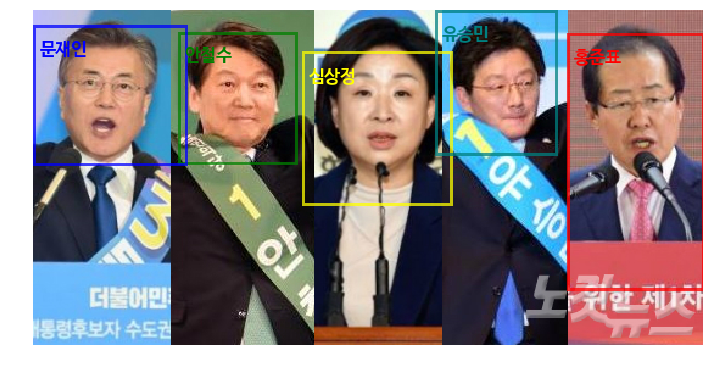

In [87]:
run_inference("samples/all.jpg", is_heatmap=False, save=False, save_dir='video_res')
# run_inference("../datasets/presidential_debate_frames_v2/frame040.jpg", is_heatmap=False, save=False, save_dir=None)

In [76]:
paths = glob("samples/*.jpg")

[[[[0.8  0.82 0.86 0.91 0.96 0.98 0.99 0.99 0.99 0.98 0.94 0.82 0.57
    0.37]
   [0.79 0.79 0.83 0.9  0.95 0.98 0.99 0.99 0.99 0.98 0.93 0.81 0.57
    0.36]
   [0.7  0.7  0.74 0.82 0.9  0.95 0.97 0.98 0.98 0.96 0.91 0.78 0.56
    0.36]
   [0.54 0.53 0.55 0.62 0.72 0.83 0.9  0.91 0.91 0.88 0.82 0.71 0.55
    0.4 ]]

  [[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.03
    0.07]
   [0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.03
    0.07]
   [0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.01 0.01 0.04
    0.07]
   [0.03 0.02 0.02 0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.02 0.04
    0.07]]

  [[0.13 0.13 0.13 0.12 0.09 0.04 0.02 0.02 0.02 0.02 0.03 0.07 0.16
    0.28]
   [0.11 0.1  0.09 0.09 0.07 0.03 0.01 0.01 0.01 0.02 0.03 0.06 0.13
    0.23]
   [0.09 0.08 0.08 0.08 0.07 0.04 0.02 0.02 0.02 0.02 0.03 0.05 0.12
    0.2 ]
   [0.1  0.09 0.08 0.09 0.08 0.06 0.04 0.04 0.04 0.04 0.06 0.08 0.14
    0.21]]

  [[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


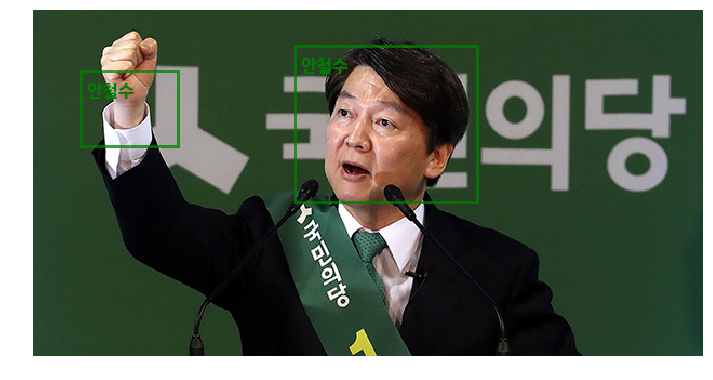

[[[[0.72 0.69 0.66 0.58 0.52 0.42 0.38 0.4  0.48 0.54 0.56]
   [0.72 0.68 0.64 0.57 0.51 0.41 0.38 0.4  0.52 0.59 0.61]
   [0.69 0.64 0.6  0.55 0.51 0.44 0.41 0.44 0.57 0.64 0.66]
   [0.62 0.55 0.51 0.47 0.47 0.42 0.4  0.44 0.57 0.65 0.67]
   [0.53 0.46 0.42 0.41 0.42 0.39 0.38 0.41 0.53 0.6  0.63]]

  [[0.02 0.01 0.01 0.02 0.03 0.03 0.02 0.01 0.   0.   0.  ]
   [0.01 0.01 0.01 0.02 0.03 0.02 0.01 0.01 0.   0.   0.  ]
   [0.01 0.01 0.01 0.02 0.03 0.03 0.01 0.01 0.   0.   0.  ]
   [0.02 0.02 0.02 0.03 0.03 0.03 0.01 0.01 0.   0.   0.  ]
   [0.02 0.02 0.02 0.03 0.04 0.03 0.02 0.01 0.01 0.   0.  ]]

  [[0.   0.   0.   0.01 0.01 0.03 0.11 0.38 0.69 0.76 0.77]
   [0.   0.   0.   0.01 0.01 0.03 0.11 0.39 0.71 0.78 0.78]
   [0.   0.   0.   0.01 0.01 0.03 0.13 0.42 0.72 0.79 0.78]
   [0.01 0.   0.01 0.01 0.02 0.05 0.17 0.46 0.74 0.8  0.78]
   [0.02 0.01 0.02 0.03 0.04 0.09 0.21 0.46 0.68 0.74 0.71]]

  [[0.44 0.49 0.47 0.41 0.33 0.22 0.1  0.04 0.01 0.01 0.01]
   [0.43 0.48 0.46 0.39 0.29 0.19 

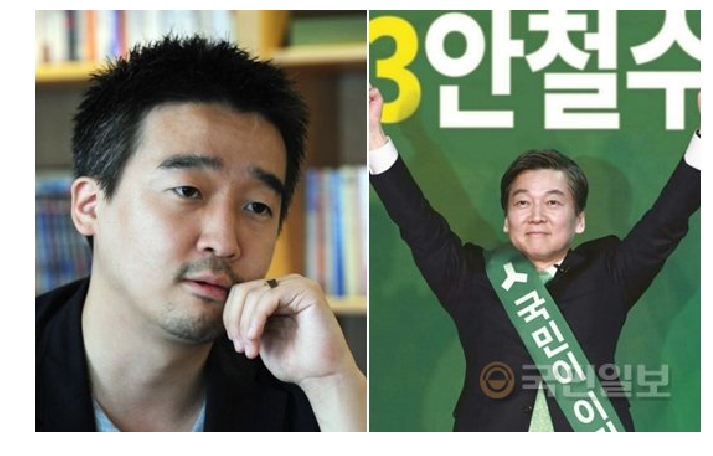

[[[[0.29 0.26 0.27 0.39 0.65 0.85 0.92 0.92 0.92 0.88]
   [0.37 0.34 0.34 0.44 0.64 0.82 0.9  0.9  0.89 0.85]
   [0.42 0.4  0.41 0.47 0.6  0.75 0.83 0.83 0.82 0.77]]

  [[0.02 0.02 0.02 0.01 0.   0.   0.   0.   0.   0.  ]
   [0.04 0.04 0.03 0.02 0.01 0.   0.   0.   0.   0.01]
   [0.06 0.05 0.04 0.03 0.02 0.01 0.01 0.01 0.01 0.01]]

  [[0.26 0.31 0.39 0.41 0.32 0.22 0.17 0.16 0.16 0.16]
   [0.19 0.23 0.29 0.31 0.25 0.18 0.14 0.14 0.14 0.14]
   [0.16 0.18 0.22 0.22 0.18 0.14 0.11 0.12 0.12 0.13]]

  [[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.02 0.02 0.01 0.01 0.01 0.01 0.   0.   0.   0.01]]

  [[0.21 0.19 0.12 0.06 0.03 0.01 0.01 0.01 0.01 0.02]
   [0.26 0.23 0.16 0.08 0.04 0.02 0.01 0.01 0.02 0.03]
   [0.3  0.29 0.23 0.13 0.07 0.04 0.03 0.03 0.03 0.05]]]]
[0]
157 159
79 69


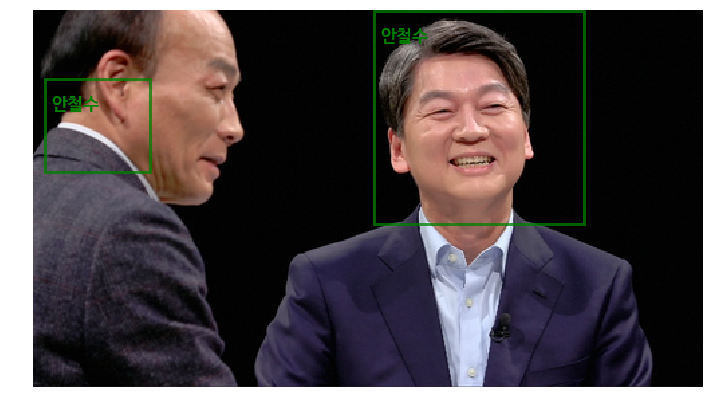

[[[[0.1  0.16 0.24 0.33 0.34 0.13 0.03 0.01 0.01 0.   0.   0.  ]
   [0.09 0.15 0.22 0.3  0.32 0.14 0.05 0.02 0.01 0.01 0.   0.  ]
   [0.1  0.14 0.18 0.22 0.23 0.13 0.06 0.03 0.02 0.01 0.01 0.01]]

  [[0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.02 0.1  0.32 0.63]
   [0.   0.   0.01 0.01 0.01 0.01 0.01 0.02 0.04 0.17 0.44 0.72]
   [0.01 0.01 0.01 0.02 0.02 0.02 0.03 0.04 0.08 0.24 0.48 0.7 ]]

  [[0.79 0.55 0.21 0.04 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
   [0.7  0.45 0.17 0.04 0.01 0.01 0.01 0.02 0.02 0.01 0.01 0.01]
   [0.49 0.31 0.14 0.05 0.02 0.02 0.03 0.03 0.03 0.02 0.02 0.02]]

  [[0.01 0.02 0.06 0.23 0.5  0.62 0.65 0.64 0.45 0.16 0.05 0.01]
   [0.01 0.03 0.08 0.27 0.52 0.64 0.65 0.64 0.47 0.18 0.05 0.02]
   [0.03 0.06 0.15 0.35 0.57 0.65 0.66 0.64 0.48 0.23 0.09 0.03]]

  [[0.   0.01 0.01 0.01 0.02 0.06 0.16 0.31 0.38 0.38 0.42 0.42]
   [0.01 0.01 0.01 0.02 0.02 0.06 0.14 0.24 0.29 0.29 0.32 0.32]
   [0.03 0.03 0.03 0.04 0.04 0.07 0.13 0.19 0.22 0.22 0.25 0.27]]]]
[]


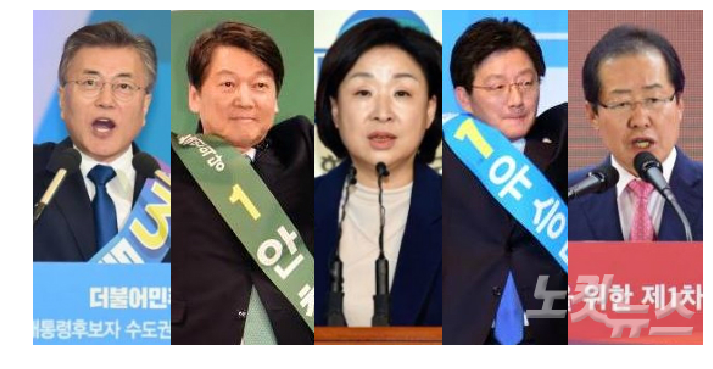

[[[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.04 0.13
    0.3 ]
   [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.05 0.16
    0.36]
   [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.04 0.11 0.25
    0.45]
   [0.01 0.02 0.02 0.03 0.03 0.03 0.04 0.04 0.04 0.06 0.11 0.21 0.35
    0.49]
   [0.04 0.05 0.06 0.09 0.11 0.14 0.16 0.18 0.18 0.22 0.28 0.37 0.45
    0.52]
   [0.09 0.12 0.16 0.21 0.26 0.31 0.34 0.36 0.37 0.38 0.41 0.44 0.49
    0.52]
   [0.2  0.24 0.28 0.32 0.36 0.38 0.38 0.39 0.39 0.39 0.41 0.44 0.48
    0.51]
   [0.27 0.31 0.35 0.38 0.4  0.39 0.38 0.37 0.36 0.35 0.36 0.39 0.44
    0.46]]

  [[0.09 0.1  0.1  0.08 0.05 0.02 0.01 0.   0.   0.   0.   0.   0.
    0.  ]
   [0.06 0.06 0.06 0.06 0.04 0.02 0.01 0.   0.   0.   0.   0.   0.
    0.  ]
   [0.04 0.04 0.05 0.06 0.05 0.02 0.01 0.01 0.   0.   0.   0.   0.
    0.  ]
   [0.05 0.06 0.07 0.09 0.09 0.05 0.03 0.02 0.02 0.02 0.01 0.01 0.01
    0.01]
   [0.08 0.1  0.13 0.18 0.2  0.14 0.09 0.06 0.06 0.06 0.

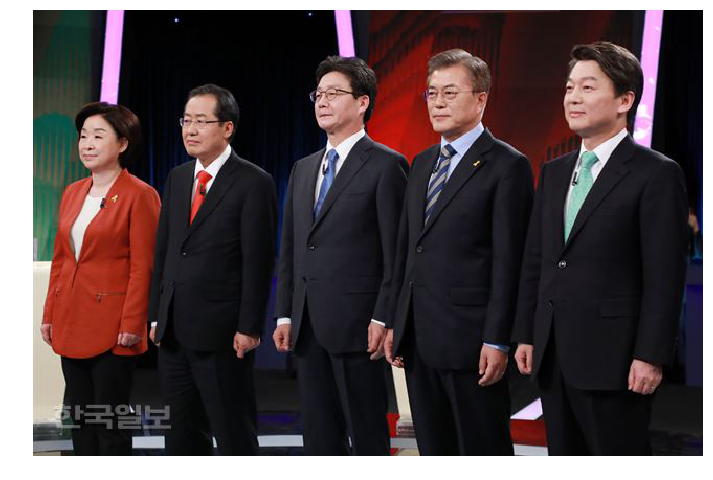

[[[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  ]
   [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.01]
   [0.01 0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
    0.01]
   [0.02 0.02 0.02 0.03 0.04 0.04 0.04 0.05 0.05 0.04 0.04 0.04 0.05
    0.07]
   [0.07 0.08 0.08 0.11 0.14 0.16 0.17 0.19 0.19 0.19 0.18 0.2  0.23
    0.24]
   [0.18 0.2  0.21 0.25 0.28 0.3  0.32 0.35 0.36 0.37 0.38 0.39 0.42
    0.43]]

  [[0.02 0.02 0.03 0.05 0.06 0.06 0.04 0.02 0.01 0.01 0.01 0.   0.
    0.01]
   [0.02 0.02 0.03 0.04 0.06 0.06 0.04 0.02 0.02 0.01 0.01 0.   0.
    0.01]
   [0.02 0.02 0.03 0.04 0.05 0.05 0.04 0.03 0.02 0.02 0.01 0.01 0.01
    0.01]
   [0.02 0.02 0.03 0.04 0.05 0.05 0.04 0.03 0.03 0.02 0.02 0.01 0.01
    0.02]
   [0.04 0.04 0.04 0.06 0.07 0.06 0.05 0.05 0.05 0.04 0.04 0.03 0.04
    0.04]
   [0.08 0.08 0.08 0.09 0.11 0.1  0.08 0.07 0.07 0.07 0.06 0.06 0.06
    0.07]]

  [[0.85 0.86 0.83 0.66 0.45 0.4  0.57 0.72 0.83 0.88 0.

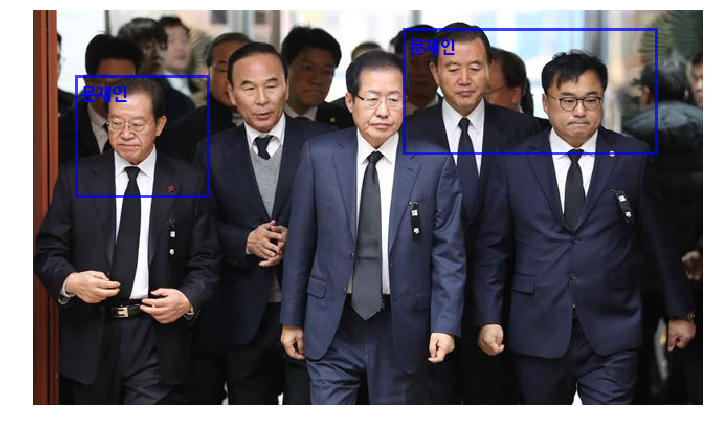

[[[[0.29 0.29 0.3  0.3  0.21 0.1  0.04 0.02 0.01 0.01 0.01 0.01]
   [0.22 0.22 0.24 0.25 0.16 0.07 0.02 0.01 0.01 0.   0.   0.01]
   [0.17 0.18 0.2  0.21 0.13 0.05 0.02 0.01 0.   0.   0.   0.  ]
   [0.16 0.18 0.2  0.21 0.14 0.06 0.02 0.01 0.   0.   0.   0.  ]
   [0.15 0.18 0.21 0.22 0.17 0.07 0.03 0.01 0.01 0.01 0.01 0.01]
   [0.15 0.19 0.23 0.24 0.2  0.1  0.05 0.03 0.02 0.02 0.02 0.02]]

  [[0.16 0.15 0.14 0.13 0.15 0.22 0.32 0.42 0.47 0.47 0.49 0.46]
   [0.19 0.17 0.15 0.13 0.16 0.29 0.49 0.66 0.72 0.71 0.72 0.67]
   [0.2  0.16 0.14 0.12 0.15 0.33 0.62 0.81 0.86 0.86 0.86 0.81]
   [0.2  0.16 0.14 0.11 0.15 0.35 0.69 0.86 0.9  0.9  0.9  0.85]
   [0.21 0.16 0.14 0.12 0.15 0.36 0.71 0.87 0.9  0.89 0.89 0.84]
   [0.21 0.16 0.13 0.11 0.13 0.29 0.63 0.82 0.85 0.84 0.84 0.77]]

  [[0.08 0.08 0.08 0.08 0.08 0.08 0.09 0.1  0.11 0.11 0.11 0.13]
   [0.09 0.1  0.11 0.11 0.11 0.09 0.08 0.08 0.07 0.07 0.07 0.08]
   [0.12 0.13 0.15 0.16 0.14 0.1  0.06 0.05 0.05 0.04 0.04 0.05]
   [0.11 0.13 0.16 0.

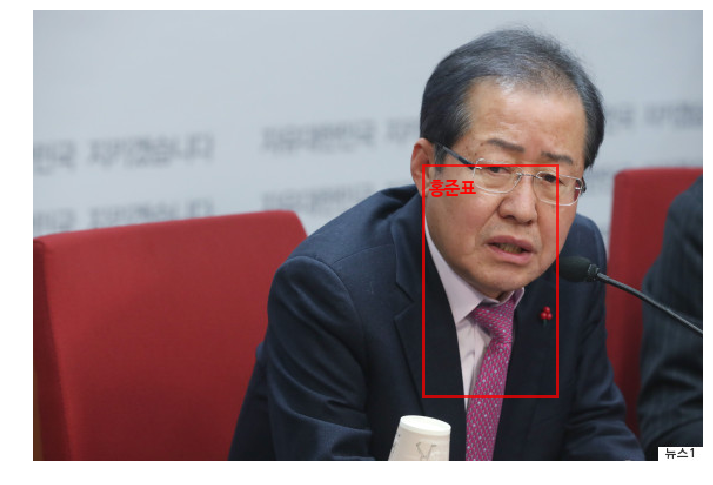

[[[[0.01 0.01 0.01 0.01 0.05 0.21 0.49 0.67 0.73 0.71]
   [0.   0.   0.   0.01 0.04 0.18 0.49 0.69 0.76 0.75]
   [0.   0.   0.   0.01 0.03 0.15 0.46 0.68 0.76 0.75]
   [0.   0.   0.   0.01 0.03 0.13 0.38 0.58 0.66 0.65]
   [0.01 0.01 0.01 0.01 0.03 0.11 0.26 0.39 0.45 0.44]]

  [[0.83 0.83 0.83 0.76 0.58 0.31 0.12 0.04 0.01 0.01]
   [0.89 0.88 0.89 0.84 0.68 0.36 0.12 0.04 0.02 0.01]
   [0.91 0.9  0.9  0.88 0.74 0.41 0.15 0.05 0.02 0.01]
   [0.9  0.89 0.9  0.88 0.76 0.48 0.21 0.09 0.05 0.03]
   [0.85 0.84 0.85 0.83 0.71 0.47 0.26 0.15 0.1  0.07]]

  [[0.05 0.05 0.05 0.04 0.03 0.01 0.01 0.   0.   0.  ]
   [0.04 0.04 0.04 0.03 0.02 0.01 0.01 0.   0.   0.  ]
   [0.03 0.03 0.03 0.02 0.02 0.01 0.01 0.   0.   0.  ]
   [0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.   0.  ]
   [0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.02 0.01 0.01]]

  [[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
   [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
   [0.01 0.01 0.01 0.01 0.01 0.02 0.01 0.01 0.01 0.01]
   [

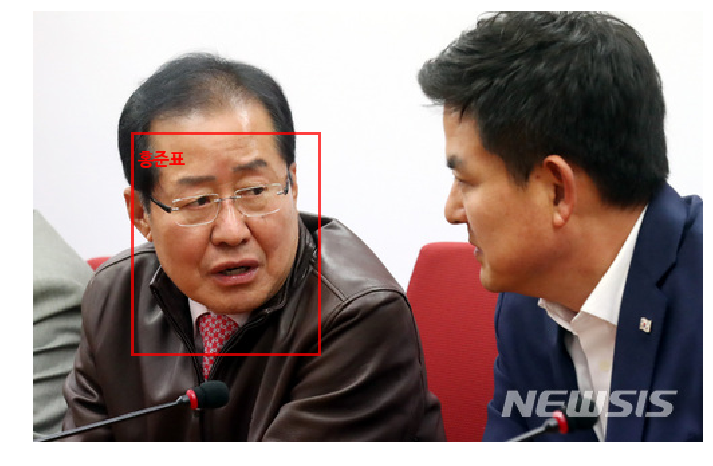

[[[[0.22 0.2  0.22 0.16 0.06 0.02 0.01 0.01 0.02 0.02 0.03]
   [0.21 0.19 0.19 0.13 0.05 0.02 0.01 0.01 0.01 0.02 0.03]
   [0.19 0.17 0.17 0.12 0.07 0.03 0.02 0.02 0.02 0.03 0.04]
   [0.19 0.17 0.17 0.15 0.11 0.08 0.06 0.06 0.07 0.08 0.09]]

  [[0.05 0.04 0.04 0.02 0.01 0.01 0.   0.   0.   0.   0.01]
   [0.03 0.03 0.03 0.02 0.01 0.01 0.   0.   0.   0.   0.  ]
   [0.03 0.03 0.03 0.02 0.01 0.01 0.   0.   0.   0.   0.  ]
   [0.03 0.03 0.03 0.03 0.02 0.02 0.01 0.01 0.01 0.01 0.01]]

  [[0.39 0.38 0.34 0.45 0.72 0.91 0.96 0.96 0.96 0.97 0.94]
   [0.41 0.4  0.37 0.49 0.75 0.91 0.96 0.96 0.96 0.96 0.93]
   [0.43 0.42 0.4  0.48 0.67 0.83 0.9  0.9  0.89 0.89 0.84]
   [0.45 0.44 0.41 0.44 0.52 0.62 0.69 0.68 0.66 0.67 0.63]]

  [[0.1  0.1  0.1  0.07 0.03 0.02 0.01 0.01 0.01 0.01 0.02]
   [0.11 0.11 0.11 0.08 0.05 0.03 0.02 0.02 0.02 0.02 0.02]
   [0.12 0.12 0.13 0.11 0.08 0.05 0.04 0.04 0.04 0.04 0.05]
   [0.13 0.12 0.13 0.13 0.12 0.1  0.1  0.11 0.11 0.1  0.11]]

  [[0.09 0.09 0.08 0.06 0.03 0.0

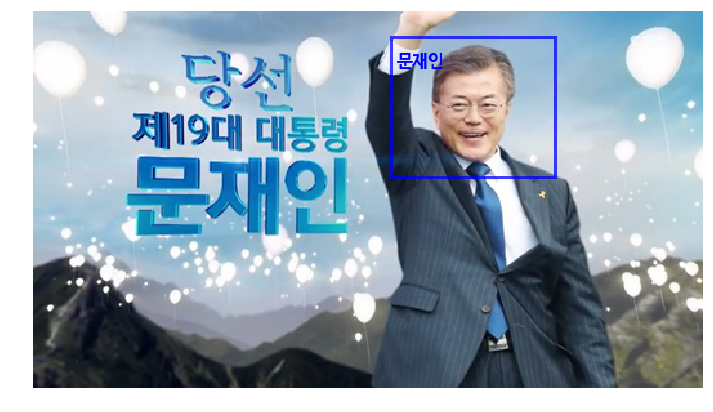

[[[[0.3  0.33 0.33 0.33 0.33 0.3  0.25]
   [0.26 0.24 0.19 0.16 0.13 0.12 0.1 ]
   [0.23 0.16 0.1  0.06 0.04 0.04 0.03]
   [0.22 0.13 0.06 0.03 0.02 0.01 0.01]
   [0.23 0.12 0.05 0.02 0.01 0.01 0.01]
   [0.22 0.11 0.04 0.01 0.01 0.   0.  ]
   [0.22 0.09 0.03 0.01 0.   0.   0.  ]
   [0.21 0.09 0.03 0.01 0.   0.   0.  ]
   [0.21 0.11 0.04 0.02 0.01 0.01 0.01]
   [0.19 0.14 0.08 0.04 0.03 0.03 0.03]
   [0.17 0.14 0.11 0.08 0.07 0.08 0.08]
   [0.14 0.14 0.12 0.1  0.1  0.11 0.11]
   [0.12 0.13 0.13 0.13 0.14 0.15 0.17]
   [0.1  0.11 0.13 0.15 0.17 0.2  0.21]]

  [[0.09 0.1  0.1  0.1  0.11 0.11 0.11]
   [0.09 0.08 0.07 0.06 0.06 0.06 0.07]
   [0.09 0.06 0.04 0.04 0.03 0.03 0.04]
   [0.11 0.06 0.03 0.03 0.02 0.02 0.03]
   [0.12 0.07 0.04 0.04 0.04 0.04 0.04]
   [0.13 0.08 0.06 0.06 0.07 0.07 0.07]
   [0.13 0.09 0.07 0.09 0.11 0.11 0.11]
   [0.12 0.08 0.08 0.12 0.15 0.16 0.16]
   [0.1  0.08 0.09 0.15 0.22 0.23 0.23]
   [0.08 0.08 0.11 0.2  0.31 0.34 0.34]
   [0.07 0.08 0.12 0.24 0.35 0.39 0.4 

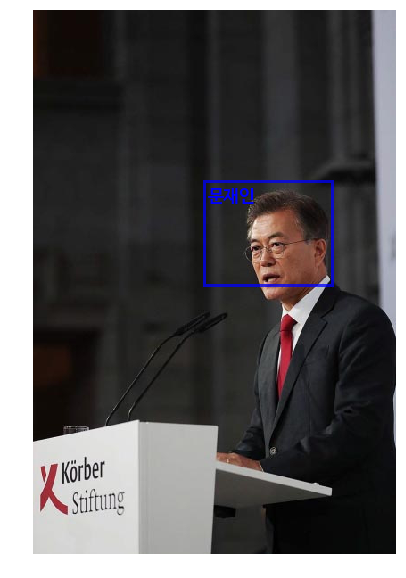

[[[[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03 0.02
    0.02]
   [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.02
    0.01]
   [0.02 0.02 0.01 0.01 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.02
    0.01]
   [0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.04 0.03 0.02
    0.02]
   [0.05 0.03 0.03 0.02 0.02 0.03 0.03 0.04 0.04 0.05 0.05 0.04 0.03
    0.03]
   [0.07 0.05 0.04 0.03 0.03 0.04 0.04 0.05 0.07 0.07 0.07 0.06 0.05
    0.05]
   [0.11 0.08 0.07 0.06 0.06 0.07 0.07 0.08 0.1  0.11 0.1  0.09 0.07
    0.07]]

  [[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
    0.01]
   [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01
    0.01]
   [0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  ]
   [0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  ]
   [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.
    0.  ]
   [0.03 0.03 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.

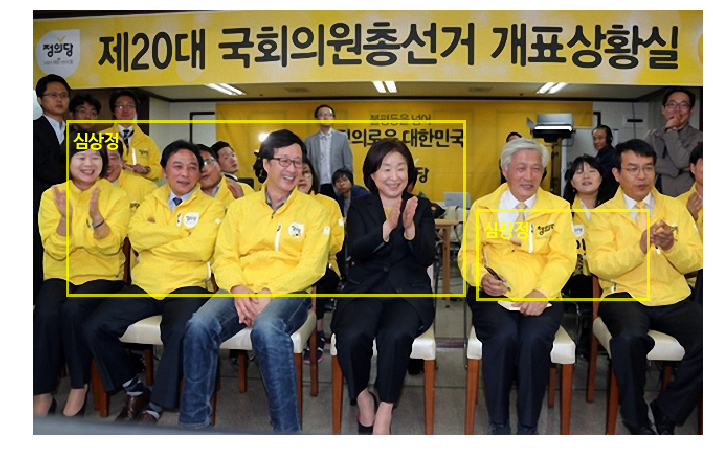

[[[[0.   0.   0.   0.01 0.02 0.06 0.12 0.11 0.08 0.05]
   [0.   0.   0.   0.01 0.02 0.05 0.11 0.11 0.09 0.06]
   [0.   0.01 0.01 0.01 0.03 0.07 0.12 0.13 0.11 0.09]
   [0.01 0.02 0.02 0.03 0.05 0.09 0.14 0.14 0.14 0.13]
   [0.04 0.04 0.05 0.07 0.09 0.12 0.15 0.16 0.16 0.16]
   [0.1  0.1  0.1  0.12 0.14 0.15 0.16 0.17 0.19 0.2 ]]

  [[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.   0.  ]
   [0.01 0.01 0.01 0.02 0.01 0.01 0.01 0.01 0.01 0.  ]
   [0.02 0.02 0.03 0.04 0.03 0.02 0.02 0.01 0.01 0.01]
   [0.04 0.06 0.08 0.08 0.07 0.05 0.03 0.02 0.01 0.01]
   [0.07 0.11 0.15 0.15 0.12 0.09 0.06 0.03 0.02 0.02]]

  [[0.   0.   0.01 0.01 0.04 0.09 0.18 0.21 0.17 0.12]
   [0.   0.   0.01 0.02 0.04 0.1  0.2  0.23 0.18 0.13]
   [0.01 0.01 0.02 0.03 0.06 0.12 0.2  0.22 0.19 0.15]
   [0.02 0.02 0.03 0.04 0.07 0.12 0.17 0.19 0.18 0.16]
   [0.03 0.04 0.05 0.06 0.09 0.12 0.15 0.17 0.18 0.18]
   [0.06 0.06 0.08 0.09 0.1  0.12 0.15 0.17 0.19 0.19]]

  [[

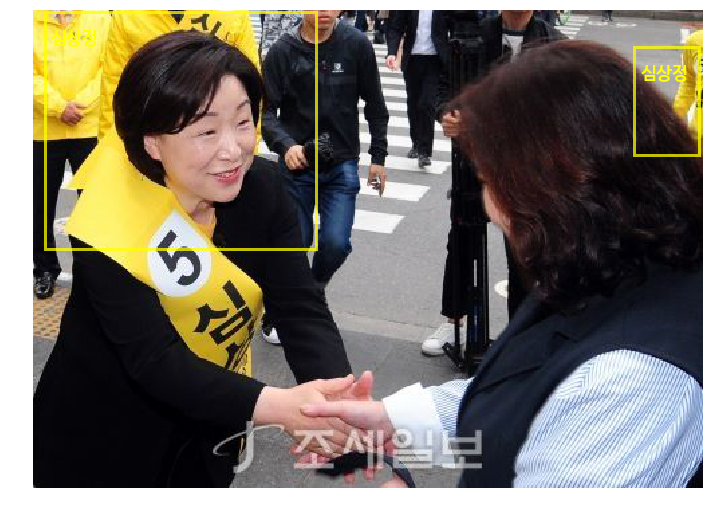

[[[[0.33 0.28 0.2  0.13 0.08 0.06 0.04 0.02 0.01 0.   0.   0.   0.
    0.  ]
   [0.3  0.26 0.2  0.13 0.08 0.07 0.05 0.02 0.01 0.   0.   0.   0.
    0.01]
   [0.27 0.24 0.18 0.13 0.09 0.08 0.06 0.03 0.02 0.01 0.01 0.01 0.01
    0.01]
   [0.21 0.2  0.17 0.13 0.09 0.08 0.07 0.05 0.03 0.02 0.02 0.02 0.02
    0.02]
   [0.18 0.18 0.17 0.15 0.12 0.1  0.09 0.08 0.06 0.05 0.05 0.05 0.05
    0.05]
   [0.16 0.18 0.19 0.19 0.16 0.14 0.13 0.12 0.11 0.09 0.08 0.07 0.07
    0.07]]

  [[0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.01 0.   0.
    0.  ]
   [0.   0.   0.   0.   0.   0.01 0.01 0.01 0.   0.   0.   0.   0.
    0.  ]
   [0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.
    0.  ]
   [0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01
    0.01]
   [0.01 0.01 0.01 0.02 0.02 0.03 0.03 0.03 0.02 0.02 0.02 0.02 0.02
    0.02]
   [0.02 0.02 0.03 0.03 0.04 0.04 0.04 0.04 0.03 0.03 0.03 0.03 0.03
    0.02]]

  [[0.13 0.11 0.11 0.11 0.11 0.11 0.11 0.09 0.07 0.06 0.06

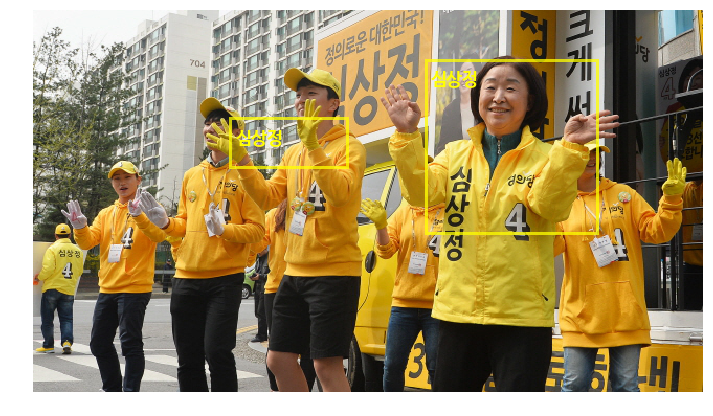

[[[[0.01]
   [0.01]]

  [[0.01]
   [0.02]]

  [[0.13]
   [0.16]]

  [[0.02]
   [0.03]]

  [[0.49]
   [0.44]]]]
[]


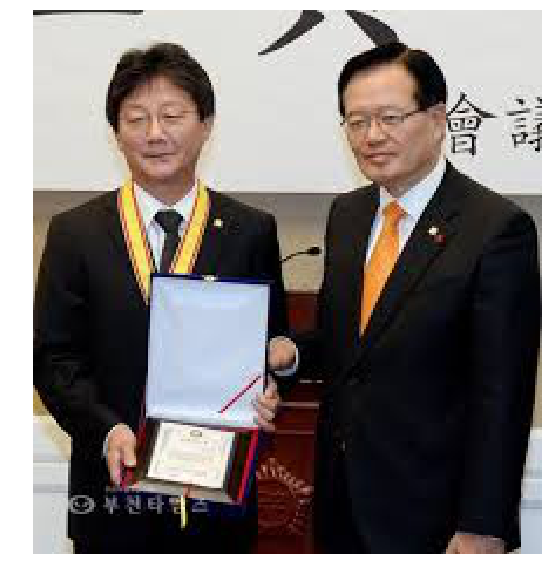

[[[[0.28 0.28 0.29 0.27 0.16 0.07 0.02 0.01 0.   0.   0.   0.01 0.02
    0.06 0.14 0.26 0.28 0.28 0.27]
   [0.24 0.25 0.26 0.25 0.15 0.06 0.02 0.   0.   0.   0.   0.   0.01
    0.04 0.11 0.21 0.23 0.23 0.23]
   [0.21 0.21 0.23 0.23 0.14 0.05 0.01 0.   0.   0.   0.   0.   0.01
    0.03 0.08 0.17 0.19 0.19 0.2 ]
   [0.21 0.21 0.22 0.22 0.14 0.06 0.02 0.01 0.   0.   0.   0.   0.01
    0.03 0.08 0.16 0.17 0.18 0.19]
   [0.22 0.22 0.23 0.23 0.17 0.09 0.04 0.01 0.01 0.01 0.01 0.01 0.02
    0.04 0.09 0.15 0.16 0.17 0.19]
   [0.25 0.24 0.24 0.25 0.21 0.14 0.07 0.04 0.02 0.02 0.02 0.02 0.03
    0.06 0.1  0.15 0.16 0.18 0.2 ]
   [0.29 0.28 0.27 0.28 0.25 0.18 0.12 0.07 0.05 0.05 0.04 0.04 0.05
    0.08 0.12 0.15 0.16 0.19 0.21]
   [0.34 0.32 0.31 0.3  0.28 0.22 0.16 0.12 0.1  0.1  0.08 0.08 0.08
    0.1  0.13 0.15 0.16 0.19 0.23]
   [0.36 0.33 0.31 0.29 0.27 0.23 0.18 0.16 0.15 0.15 0.13 0.11 0.11
    0.12 0.14 0.16 0.17 0.2  0.24]]

  [[0.06 0.06 0.07 0.06 0.03 0.02 0.01 0.   0.   0.   0.   0. 

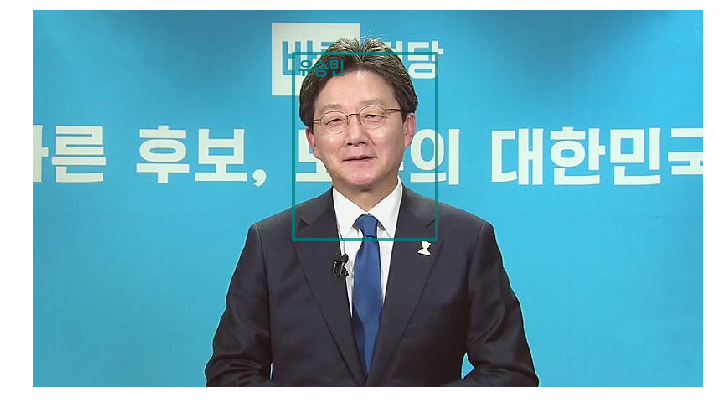

[[[[0.01 0.01 0.01 0.02 0.05 0.13 0.25 0.33 0.48 0.69 0.85 0.92 0.94
    0.94]
   [0.01 0.01 0.01 0.02 0.05 0.13 0.24 0.32 0.49 0.7  0.86 0.92 0.94
    0.94]
   [0.02 0.02 0.02 0.04 0.07 0.15 0.23 0.29 0.45 0.66 0.82 0.89 0.92
    0.92]
   [0.07 0.06 0.06 0.08 0.12 0.18 0.22 0.26 0.37 0.56 0.72 0.8  0.84
    0.84]
   [0.16 0.15 0.14 0.17 0.19 0.22 0.23 0.24 0.3  0.43 0.56 0.61 0.65
    0.65]
   [0.31 0.29 0.27 0.27 0.27 0.26 0.24 0.22 0.27 0.35 0.43 0.44 0.46
    0.47]]

  [[0.   0.   0.   0.01 0.04 0.14 0.3  0.34 0.18 0.06 0.02 0.01 0.01
    0.01]
   [0.   0.   0.   0.01 0.03 0.11 0.24 0.27 0.13 0.04 0.01 0.   0.
    0.  ]
   [0.   0.   0.   0.01 0.03 0.09 0.2  0.22 0.11 0.03 0.01 0.   0.
    0.  ]
   [0.01 0.   0.01 0.01 0.03 0.08 0.15 0.16 0.09 0.03 0.01 0.   0.
    0.  ]
   [0.01 0.01 0.01 0.02 0.04 0.08 0.13 0.13 0.08 0.03 0.01 0.01 0.01
    0.01]
   [0.02 0.02 0.02 0.02 0.04 0.08 0.11 0.11 0.07 0.03 0.01 0.01 0.01
    0.01]]

  [[0.   0.   0.   0.01 0.02 0.05 0.11 0.14 0.08 0.03 

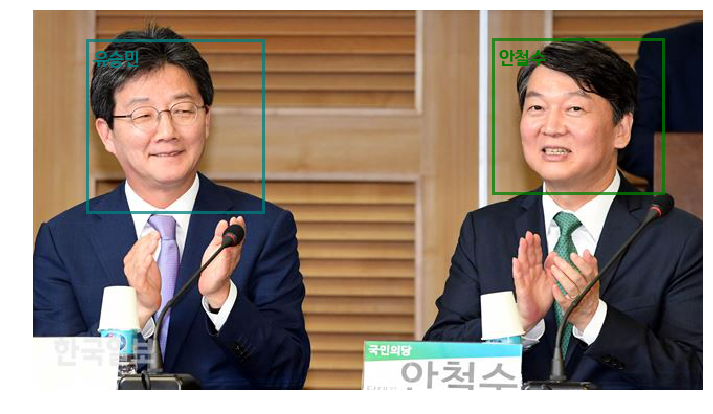

In [77]:
for p in paths:
    run_inference(p, is_heatmap=False, save=False, save_dir=None)

In [ ]:
import glob

In [ ]:
paths = sorted(glob.glob("../datasets/presidential_debate_frames_v2/*.jpg"))

In [ ]:
for p in paths:
    run_inference(p, is_heatmap=False, save=True, save_dir='video_mse')